# TASK - 1 - PRE-PROCESSING

# Setup and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set vibrant style for all plots
sns.set_theme(style="whitegrid", palette="viridis")

# Load Data
df = pd.read_csv('usgs_earthquake_data_2000_2025.csv')
df['time'] = pd.to_datetime(df['time'])

# Initial Clean (Drop completely empty or irrelevant columns)
cols_to_drop = ['dmin', 'horizontalError', 'depthError', 'magError', 'magNst', 'locationSource', 'magSource']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df_clean = df_clean.dropna(subset=['mag', 'depth', 'latitude', 'longitude'])

print("Data Loaded. Shape:", df_clean.shape)

Data Loaded. Shape: (175947, 15)


# Advanced Feature Engineering (Time & Cyclical)
## Extracts temporal patterns and handles the cyclical nature of time (e.g., Hour 23 is close to Hour 0).

In [3]:
# 1. Extract Basic Time Components
df_clean['year'] = df_clean['time'].dt.year
df_clean['month'] = df_clean['time'].dt.month
df_clean['day'] = df_clean['time'].dt.day
df_clean['hour'] = df_clean['time'].dt.hour
df_clean['day_of_week'] = df_clean['time'].dt.dayofweek

# 2. Cyclical Encoding (Sine/Cosine Transformation)
# This captures that December (12) is close to January (1)
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month']/12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month']/12)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour']/24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour']/24)

print("Cyclical features added.")

Cyclical features added.


# Spatial Clustering & Density (K-Means)
## Identifies "Seismic Zones" based on location density rather than just raw coordinates.

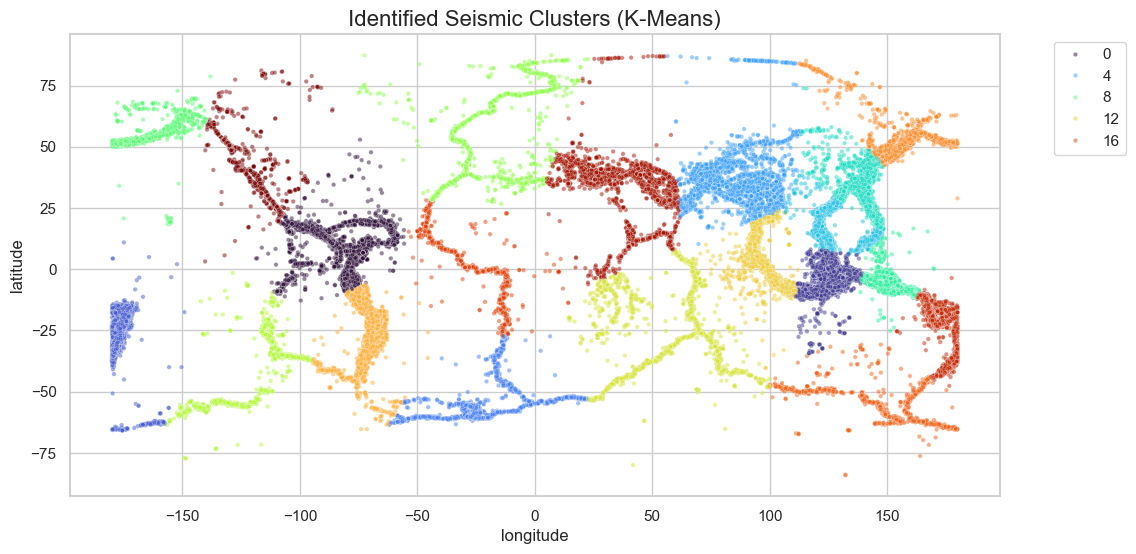

In [4]:
# 1. K-Means Clustering for Seismic Regions
# We use K=20 to find major earthquake zones globally
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
df_clean['region_cluster'] = kmeans.fit_predict(df_clean[['latitude', 'longitude']])

# 2. Distance from Cluster Center
# Calculate how far each point is from its cluster center (measure of centrality)
centers = kmeans.cluster_centers_
df_clean['dist_to_cluster_center'] = df_clean.apply(
    lambda row: np.linalg.norm(row[['latitude', 'longitude']] - centers[int(row['region_cluster'])]), axis=1
)

# Plot the Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_clean, x='longitude', y='latitude', hue='region_cluster', palette='turbo', s=10, alpha=0.5)
plt.title('Identified Seismic Clusters (K-Means)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Spatio-Temporal Lag Features
## Calculates the time elapsed since the last earthquake in the same cluster. This is crucial for predicting aftershocks or seismic gaps.

In [5]:
# Function to calculate lag features per cluster
def calculate_lags(group):
    group = group.sort_values('time')
    # Time since last event (in hours)
    group['hours_since_last_event'] = group['time'].diff().dt.total_seconds() / 3600
    # Magnitude of the previous event
    group['prev_mag'] = group['mag'].shift(1)
    # Rolling average magnitude (last 5 events)
    group['rolling_mag_5'] = group['mag'].rolling(window=5).mean()
    return group

# Apply to each cluster
df_clean = df_clean.groupby('region_cluster').apply(calculate_lags).reset_index(drop=True)

# Fill NaN values created by lag (first events in each cluster)
df_clean.fillna(0, inplace=True)

print("Lag features (Time Since Last Event, Previous Mag) created.")

Lag features (Time Since Last Event, Previous Mag) created.


# Advanced Transformations (Log & Power)
## Handles skewed data (like gap and rms) to make it more Gaussian-like for ML models.

Original Skewness:
 gap       0.423972
rms      52.140230
depth     3.406826
dtype: float64


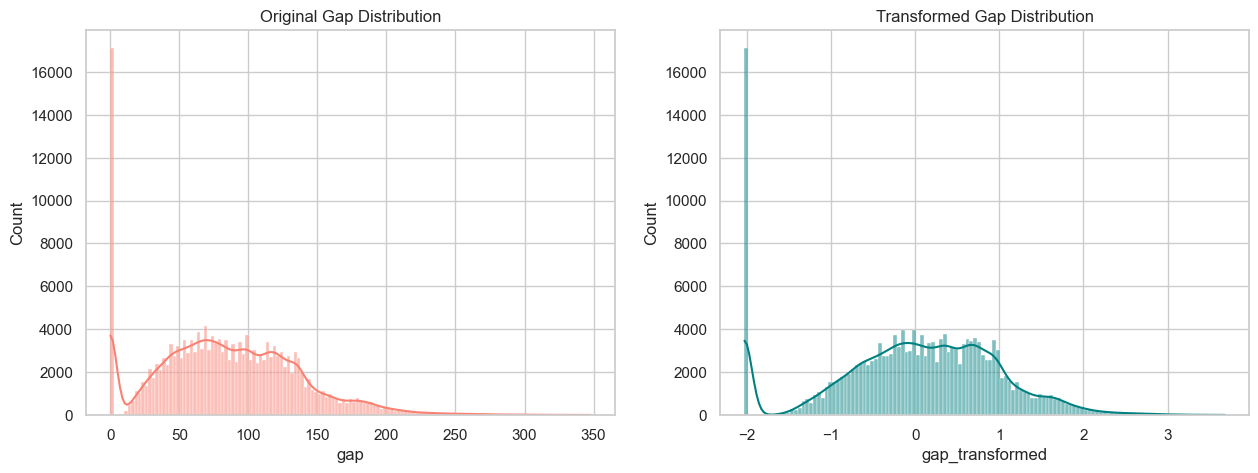

In [6]:
# Check skewness
skewed_cols = ['gap', 'rms', 'depth']
print("Original Skewness:\n", df_clean[skewed_cols].skew())

# 1. Log Transformation (with shift for negative/zero values)
# For depth, we shift by min value if negative
min_depth = df_clean['depth'].min()
shift = abs(min_depth) + 1 if min_depth < 0 else 1
df_clean['depth_log'] = np.log1p(df_clean['depth'] + shift)

# 2. Power Transformer (Yeo-Johnson) for very skewed 'gap' and 'rms'
# This is more robust than simple log
pt = PowerTransformer(method='yeo-johnson')
df_clean[['gap_transformed', 'rms_transformed']] = pt.fit_transform(df_clean[['gap', 'rms']])

# Visualize Before vs After
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_clean['gap'], kde=True, ax=axes[0], color='salmon').set_title('Original Gap Distribution')
sns.histplot(df_clean['gap_transformed'], kde=True, ax=axes[1], color='teal').set_title('Transformed Gap Distribution')
plt.show()

# Outlier Detection (Isolation Forest)
## An advanced alternative to KNN/IQR for detecting anomalies in high-dimensional space.

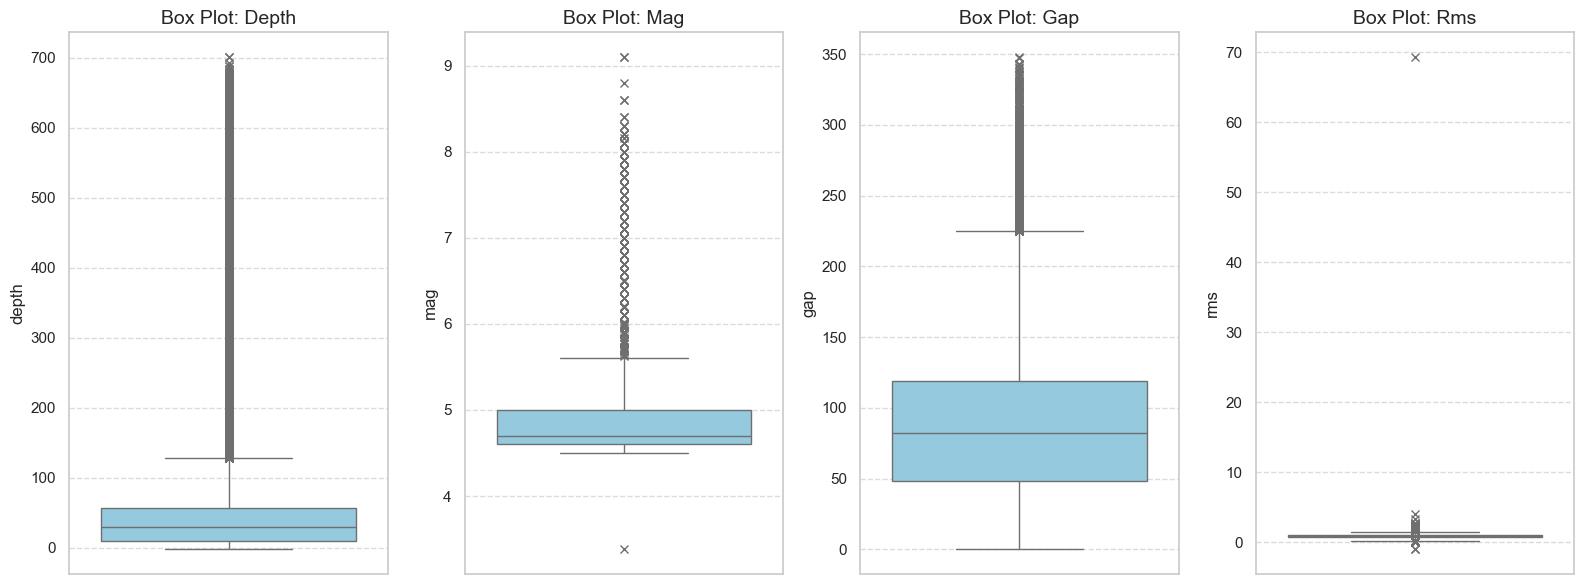

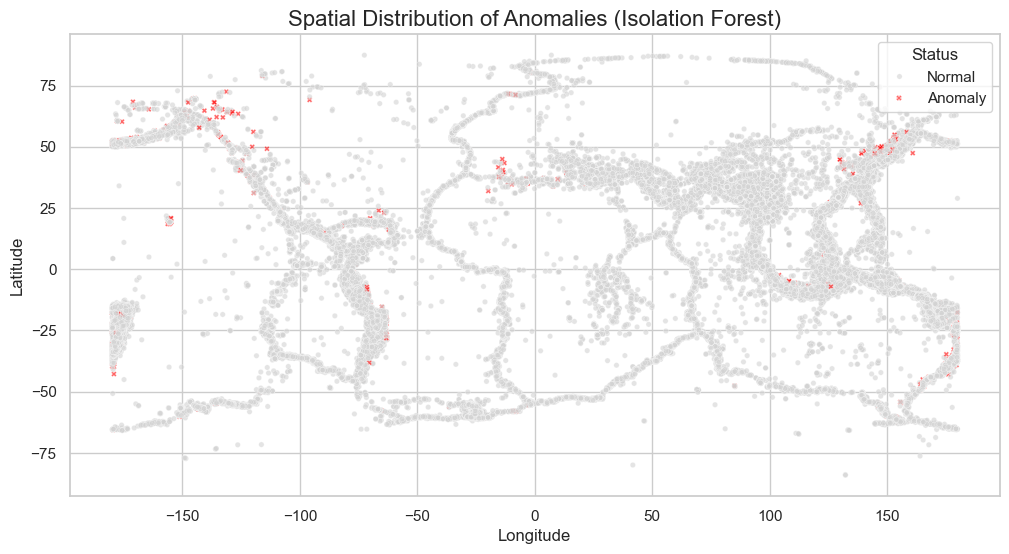

Outlier detection complete. Box plots and map generated.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors

# --- 1. VISUALIZATION: Box Plots for Outlier Detection ---
# This visualizes the distribution and outliers for each feature used in anomaly detection.
features_iso = ['depth', 'mag', 'gap', 'rms']

plt.figure(figsize=(16, 6))
# Create a grid of subplots (1 row, 4 columns)
for i, col in enumerate(features_iso):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df_clean[col], color='skyblue', flierprops={"marker": "x", "markerfacecolor": "red"})
    plt.title(f'Box Plot: {col.capitalize()}', fontsize=14)
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 2. MODELING: Isolation Forest Anomaly Detection ---
# Prepare data (handle NaNs if any remain)
X_iso = df_clean[['latitude', 'longitude', 'depth', 'mag', 'gap', 'rms']].fillna(0)

# Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42) # Top 1% anomalies
df_clean['anomaly_score'] = iso.fit_predict(X_iso)
df_clean['is_anomaly'] = df_clean['anomaly_score'].map({1: 'Normal', -1: 'Anomaly'})

# Visualization: Spatial Distribution of Anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_clean, x='longitude', y='latitude', hue='is_anomaly', 
                style='is_anomaly', palette={'Normal': 'lightgray', 'Anomaly': 'red'}, 
                alpha=0.6, s=15)
plt.title('Spatial Distribution of Anomalies (Isolation Forest)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Status')
plt.show()

print("Outlier detection complete. Box plots and map generated.")

# Dimensionality Reduction (PCA & t-SNE)
## Prepares data for visualization in 2D space.

Explained Variance Ratio: [0.20323648 0.19424029 0.14993319]


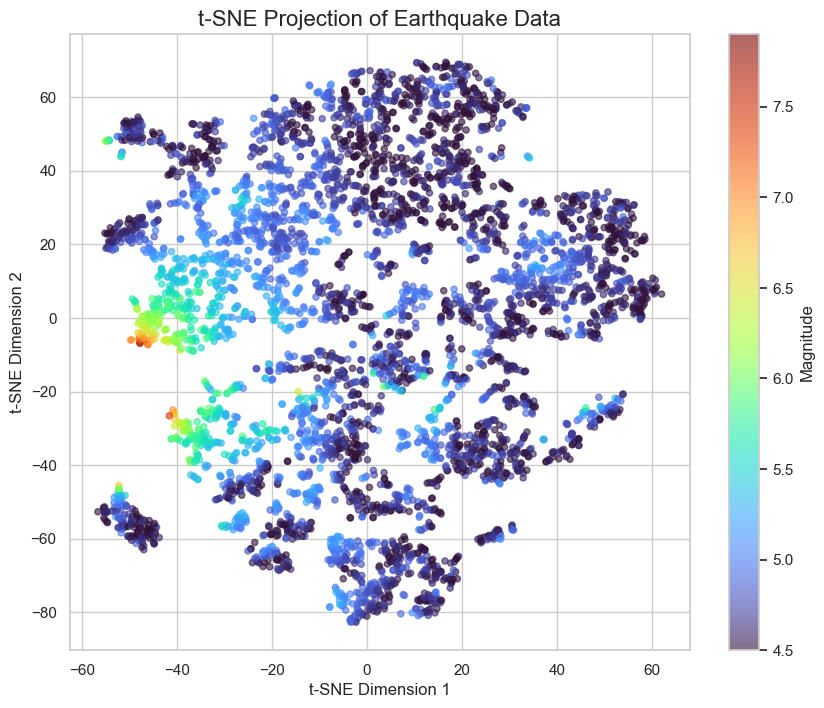

In [8]:
# 1. Standard Scaling (Crucial for PCA and t-SNE)
# Ensure no NaNs exist in the feature set
features_pca = ['latitude', 'longitude', 'depth', 'mag', 'gap', 'rms', 'hours_since_last_event']
x_pca = df_clean[features_pca].fillna(0) # Fill NaNs just in case

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_pca)

# 2. PCA (Principal Component Analysis)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_scaled)

# Store PCA results back in dataframe
df_clean['pca_1'] = pca_result[:, 0]
df_clean['pca_2'] = pca_result[:, 1]
df_clean['pca_3'] = pca_result[:, 2]

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# 3. t-SNE (t-Distributed Stochastic Neighbor Embedding)
# Sampling 5000 points because t-SNE is computationally heavy
sample_indices = np.random.choice(x_scaled.shape[0], 5000, replace=False)
x_sample = x_scaled[sample_indices]

# FIXED LINE: Removed 'n_iter' to fix TypeError
tsne = TSNE(n_components=2, perplexity=30, random_state=42) 
tsne_results = tsne.fit_transform(x_sample)

# Plot t-SNE
plt.figure(figsize=(10, 8))
# Use iloc to map colors correctly to the sampled data
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_clean.iloc[sample_indices]['mag'], 
            cmap='turbo', alpha=0.6, s=20)
plt.colorbar(label='Magnitude')
plt.title('t-SNE Projection of Earthquake Data', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


# ADDITIONAL Preprocessing & Analysis Code
## DBSCAN (Density-Based Clustering) for spatial outlier detection and Geospatial Binning.

DBSCAN: Estimated number of clusters: 460
DBSCAN: Estimated number of noise points (Outliers): 7727


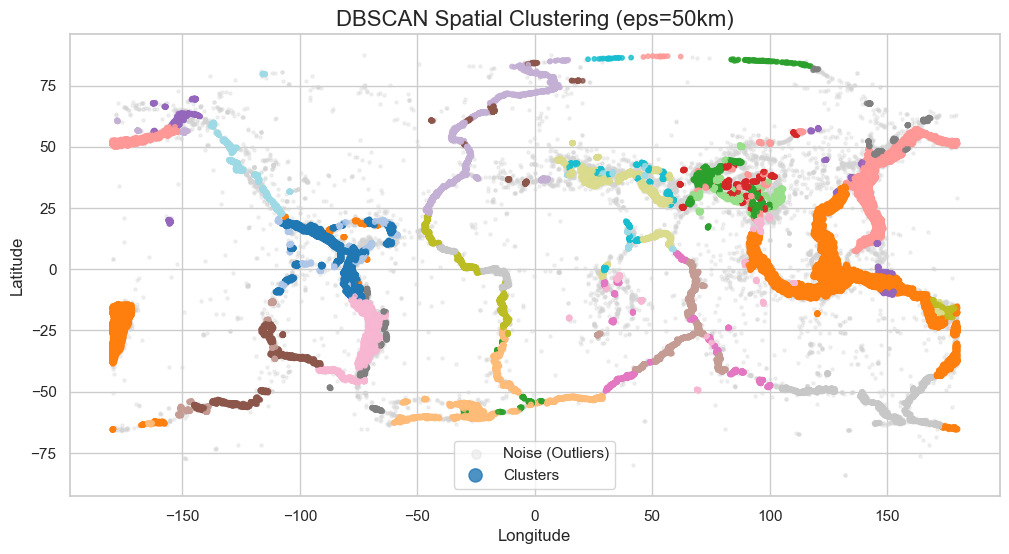

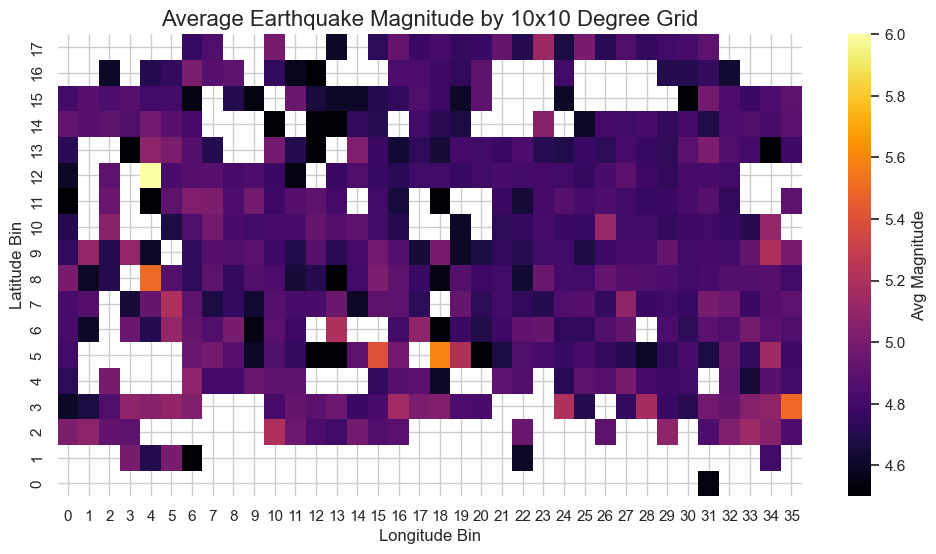

In [9]:
from sklearn.cluster import DBSCAN

# --- TASK 1: DBSCAN Clustering (Spatial Density) ---
# DBSCAN is excellent for spatial data because it finds arbitrary shapes and identifies noise (outliers).
# We use radians for geospatial distance calculation.

# Convert Lat/Lon to Radians
coords = np.radians(df_clean[['latitude', 'longitude']])

# Epsilon: Max distance between two samples to be neighbors (e.g., 50km converted to radians)
# km_per_radian = 6371.0088
# epsilon = 50km / 6371 ≈ 0.0078
kms_per_radian = 6371.0088
epsilon = 50 / kms_per_radian 

# Run DBSCAN
# min_samples: Minimum neighbors to form a core point (cluster)
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')
df_clean['dbscan_cluster'] = db.fit_predict(coords)

# Calculate Cluster Stats
n_clusters_ = len(set(df_clean['dbscan_cluster'])) - (1 if -1 in df_clean['dbscan_cluster'] else 0)
n_noise_ = list(df_clean['dbscan_cluster']).count(-1)

print(f"DBSCAN: Estimated number of clusters: {n_clusters_}")
print(f"DBSCAN: Estimated number of noise points (Outliers): {n_noise_}")

# Plot DBSCAN Results (Noise in Grey, Clusters in Color)
plt.figure(figsize=(12, 6))
# Plot Noise (Outliers)
plt.scatter(df_clean[df_clean['dbscan_cluster'] == -1]['longitude'], 
            df_clean[df_clean['dbscan_cluster'] == -1]['latitude'], 
            c='lightgray', s=5, label='Noise (Outliers)', alpha=0.3)
# Plot Clusters
plt.scatter(df_clean[df_clean['dbscan_cluster'] != -1]['longitude'], 
            df_clean[df_clean['dbscan_cluster'] != -1]['latitude'], 
            c=df_clean[df_clean['dbscan_cluster'] != -1]['dbscan_cluster'], 
            cmap='tab20', s=10, label='Clusters', alpha=0.8)

plt.title(f'DBSCAN Spatial Clustering (eps=50km)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(markerscale=3)
plt.show()


# --- TASK 2: Geospatial Grid Binning (Feature Engineering) ---
# Create a grid to treat location as a categorical feature (Region ID)
# This is useful for correlation matrices where exact lat/lon is too specific.

# Define Grid Size (e.g., 5x5 degree blocks)
lat_bins = np.arange(-90, 95, 10)
lon_bins = np.arange(-180, 185, 10)

df_clean['lat_bin'] = pd.cut(df_clean['latitude'], bins=lat_bins, labels=False)
df_clean['lon_bin'] = pd.cut(df_clean['longitude'], bins=lon_bins, labels=False)

# Create a "Grid ID"
df_clean['grid_id'] = df_clean['lat_bin'].astype(str) + "_" + df_clean['lon_bin'].astype(str)

# Calculate Average Magnitude per Grid Block
grid_stats = df_clean.groupby(['lat_bin', 'lon_bin'])['mag'].mean().unstack()

# Plot Heatmap of Seismic Intensity by Grid
plt.figure(figsize=(12, 6))
sns.heatmap(grid_stats, cmap='inferno', cbar_kws={'label': 'Avg Magnitude'})
plt.title('Average Earthquake Magnitude by 10x10 Degree Grid', fontsize=16)
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.gca().invert_yaxis() # Fix y-axis orientation for map logic
plt.show()

# Correlation Analysis & Feature Selection
## Generates a heatmap to identify redundant features.

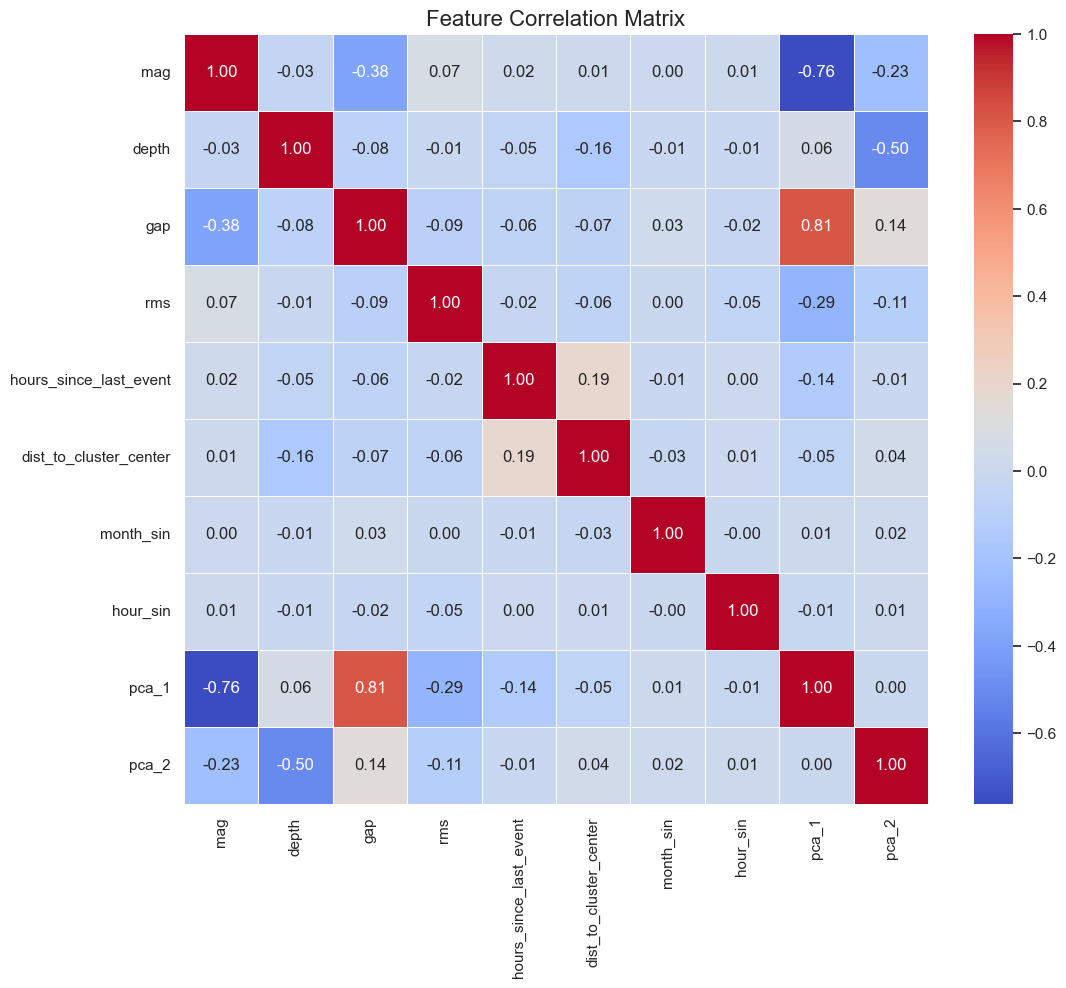

In [10]:
# Select numerical columns including new features
corr_cols = ['mag', 'depth', 'gap', 'rms', 'hours_since_last_event', 'dist_to_cluster_center', 
             'month_sin', 'hour_sin', 'pca_1', 'pca_2']


plt.figure(figsize=(12, 10))
correlation_matrix = df_clean[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

# Spatial Feature Engineering (Spatial Lags)
## Spatial Lag captures the relationship between a location and its neighbors

In [11]:
# --- 3. FEATURE ENGINEERING: Spatial Lags (Neighborhood Analysis) ---
# Calculate the average value of neighbors (Spatial Lag) for Magnitude and Depth.
# This is crucial for Spatial Autocorrelation (Moran's I) and Regression.

# 1. Setup Nearest Neighbors (using Haversine metric for geospatial distance)
# Convert Lat/Lon to Radians for Haversine
coords = np.radians(df_clean[['latitude', 'longitude']])

# Find 5 nearest neighbors for every point
knn = NearestNeighbors(n_neighbors=5, metric='haversine')
knn.fit(coords)
distances, indices = knn.kneighbors(coords)

# 2. Calculate Spatial Lag for Magnitude
# Get the magnitudes of the 5 neighbors
neighbor_mags = df_clean['mag'].values[indices]
# Calculate the mean (Spatial Lag)
df_clean['spatial_lag_mag'] = neighbor_mags.mean(axis=1)

# 3. Calculate Spatial Lag for Depth
neighbor_depths = df_clean['depth'].values[indices]
df_clean['spatial_lag_depth'] = neighbor_depths.mean(axis=1)

# 4. Local Spatial Heterogeneity (Variance of Neighbors)
# High variance means the neighbors are very different (Spatial Heterogeneity)
df_clean['local_heterogeneity_mag'] = neighbor_mags.var(axis=1)

print("Spatial Lag Features Created:")
print(df_clean[['mag', 'spatial_lag_mag', 'depth', 'spatial_lag_depth', 'local_heterogeneity_mag']].head())

# Correlation Check: Does a location's magnitude correlate with its neighbors?
correlation = df_clean['mag'].corr(df_clean['spatial_lag_mag'])
print(f"\nSpatial Autocorrelation (Approximate Moran's I for Mag): {correlation:.4f}")

Spatial Lag Features Created:
   mag  spatial_lag_mag  depth  spatial_lag_depth  local_heterogeneity_mag
0  4.7            5.062   18.0             13.604                 0.059376
1  4.8            4.700   42.2             57.992                 0.016000
2  4.6            5.060   10.0             18.016                 0.198400
3  5.0            4.900  241.0            222.704                 0.088000
4  5.6            4.860   33.0             48.770                 0.186400

Spatial Autocorrelation (Approximate Moran's I for Mag): 0.5109


# Moran's I Scatter Plot (Spatial Autocorrelation)

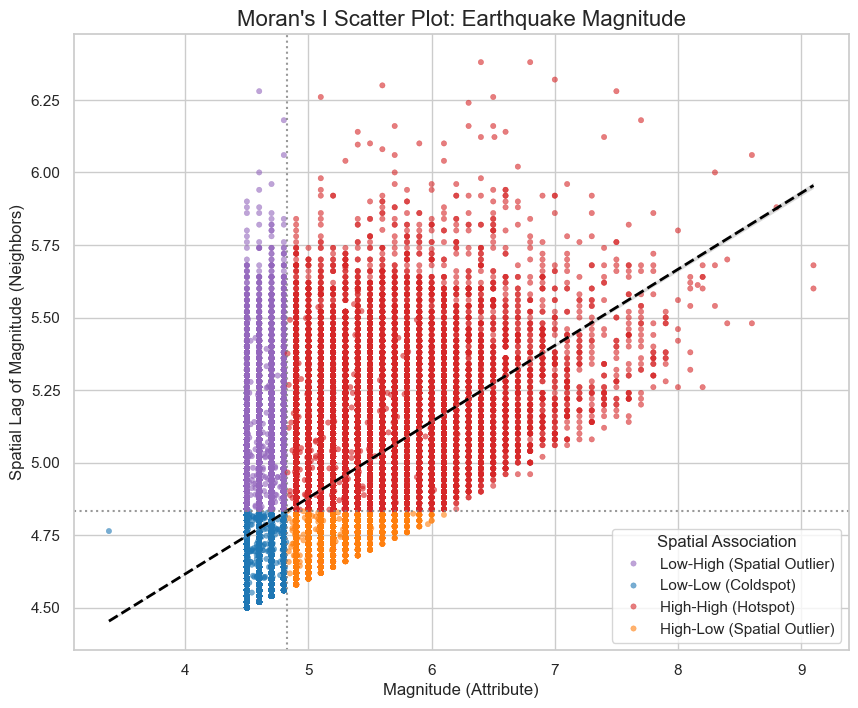

In [12]:
# --- 4. VISUALIZATION: Moran's I Scatter Plot ---
# This plot helps identify:
# - Hotspots (High Mag surrounded by High Mag) -> Red
# - Coldspots (Low Mag surrounded by Low Mag) -> Blue
# - Spatial Outliers (High surrounded by Low, or vice versa) -> Orange/Purple

plt.figure(figsize=(10, 8))

# 1. Standardize the data (Mean centering) for the plot quadrants
# This is standard practice for Moran's Plots
x = df_clean['mag']
y = df_clean['spatial_lag_mag']
x_mean = x.mean()
y_mean = y.mean()

# 2. Define Quadrants
# High-High (Hotspot), Low-Low (Coldspot), High-Low, Low-High
# We use np.select to create a categorical column for coloring
conditions = [
    (x > x_mean) & (y > y_mean),  # High-High (Red)
    (x < x_mean) & (y < y_mean),  # Low-Low (Blue)
    (x < x_mean) & (y > y_mean),  # Low-High (Light Blue/Purple)
    (x > x_mean) & (y < y_mean)   # High-Low (Orange)
]
choices = ['High-High (Hotspot)', 'Low-Low (Coldspot)', 'Low-High (Spatial Outlier)', 'High-Low (Spatial Outlier)']
df_clean['moran_quadrant'] = np.select(conditions, choices, default='Center')

# 3. Plot
# Using a custom vibrant palette
palette = {
    'High-High (Hotspot)': '#d62728',       # Red
    'Low-Low (Coldspot)': '#1f77b4',        # Blue
    'Low-High (Spatial Outlier)': '#9467bd', # Purple
    'High-Low (Spatial Outlier)': '#ff7f0e'  # Orange
}

sns.scatterplot(data=df_clean, x='mag', y='spatial_lag_mag', hue='moran_quadrant', 
                palette=palette, alpha=0.6, s=15, edgecolor=None)

# 4. Add Regression Line (Global Moran's I)
sns.regplot(data=df_clean, x='mag', y='spatial_lag_mag', scatter=False, color='black', 
            line_kws={'linestyle': '--', 'linewidth': 2, 'label': f"Global Moran's I: {df_clean['mag'].corr(df_clean['spatial_lag_mag']):.4f}"})

# 5. Add Reference Lines (Mean)
plt.axvline(x_mean, color='gray', linestyle=':', alpha=0.8)
plt.axhline(y_mean, color='gray', linestyle=':', alpha=0.8)

# Formatting
plt.title("Moran's I Scatter Plot: Earthquake Magnitude", fontsize=16)
plt.xlabel('Magnitude (Attribute)', fontsize=12)
plt.ylabel('Spatial Lag of Magnitude (Neighbors)', fontsize=12)
plt.legend(title='Spatial Association')
plt.show()

In [13]:
# ==========================================
# FINAL STEP: APPLY ALL FEATURES TO FULL DATASET & SAVE
# ==========================================
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

print("Starting final processing on full dataset...")

# 1. ENSURE TEMPORAL FEATURES EXIST
if 'time' in df_clean.columns:
    df_clean['time'] = pd.to_datetime(df_clean['time'])
    df_clean['year'] = df_clean['time'].dt.year
    df_clean['month'] = df_clean['time'].dt.month
    df_clean['day_of_year'] = df_clean['time'].dt.dayofyear
    
    # Season Logic
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    df_clean['season'] = df_clean['month'].apply(get_season)

# 2. CALCULATE SPATIAL CLUSTERS (LISA) FOR ALL POINTS
# We use n_jobs=-1 to use all CPU cores for speed
print("Calculating Spatial Clusters for all events...")
coords = np.radians(df_clean[['latitude', 'longitude']])
knn = NearestNeighbors(n_neighbors=8, metric='haversine', n_jobs=-1).fit(coords)
distances, indices = knn.kneighbors(coords)

# Calculate Spatial Lag (Mean of neighbors)
y = df_clean['mag'].values
z = (y - y.mean()) / y.std()
spatial_lag = np.array([np.mean(z[idx]) for idx in indices])

# Define Clusters
conditions = [
    (z > 0) & (spatial_lag > 0),
    (z < 0) & (spatial_lag < 0),
    (z > 0) & (spatial_lag < 0),
    (z < 0) & (spatial_lag > 0)
]
choices = ['High-High (Hotspot)', 'Low-Low (Coldspot)', 'High-Low (Outlier)', 'Low-High (Outlier)']
df_clean['lisa_cluster'] = np.select(conditions, choices, default='Insignificant')
df_clean['spatial_lag_mag'] = spatial_lag # Save the lag value too

# 3. DETECT ANOMALIES (ISOLATION FOREST) FOR ALL POINTS
print("Detecting Anomalies on full dataset...")
features_iso = ['latitude', 'longitude', 'depth', 'mag']
# Fill NaNs if any (though we dropped them earlier)
X_iso = df_clean[features_iso].fillna(0)

iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
df_clean['anomaly_score'] = iso.fit_predict(X_iso)
df_clean['is_anomaly'] = df_clean['anomaly_score'].map({1: 'Normal', -1: 'Anomaly'})

# 4. SAVE TO CSV
output_filename = 'final_preprocessed_earthquake_data.csv'
df_clean.to_csv(output_filename, index=False)

print(f"SUCCESS! Full pre-processed dataset saved to: {output_filename}")
print(f"Final Shape: {df_clean.shape}")
print("Columns saved:", df_clean.columns.tolist())

Starting final processing on full dataset...
Calculating Spatial Clusters for all events...
Detecting Anomalies on full dataset...
SUCCESS! Full pre-processed dataset saved to: final_preprocessed_earthquake_data.csv
Final Shape: (175947, 47)
Columns saved: ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst', 'gap', 'rms', 'net', 'id', 'updated', 'place', 'type', 'status', 'year', 'month', 'day', 'hour', 'day_of_week', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'dist_to_cluster_center', 'hours_since_last_event', 'prev_mag', 'rolling_mag_5', 'depth_log', 'gap_transformed', 'rms_transformed', 'anomaly_score', 'is_anomaly', 'pca_1', 'pca_2', 'pca_3', 'dbscan_cluster', 'lat_bin', 'lon_bin', 'grid_id', 'spatial_lag_mag', 'spatial_lag_depth', 'local_heterogeneity_mag', 'moran_quadrant', 'day_of_year', 'season', 'lisa_cluster']
